In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval
import os
from util.plotting import stacked_barchart
import seaborn as sns

import matplotlib.pyplot as plt
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import json
from tqdm import tqdm
tqdm.pandas()  # for pandas progress_apply()

import scipy

In [2]:
sns.set(rc={'figure.figsize': (20, 6)})
sns.set(font_scale=1.5)

In [3]:
# read df
converters = {"album_images": literal_eval, "hashtags": literal_eval, "comments_flat": literal_eval,
              "timestamp": pd.to_datetime, "image_label": literal_eval}
df = pd.read_csv("DepotBoijmans.csv", converters=converters, index_col="timestamp")
df

,shortcode,owner_username,MicroRole,MacroRole,likes,comment_count,location,owner_followercount,interactions,caption_en,hashtags,comment_en,num_images,image_label
timestamp,,,,,,,,,,,,,,
2020-01-01 14:34:39,postaf1cd604a7f645109218b27f109b3fea1b6720faee...,user8392bf148647eddd2fc3e3edf65add3268736213ed...,Individual,Private,27,2,NaN,93,29,#rotterdam#nederland#netherlands #holland#depo...,"[rotterdam, nederland, netherlands, holland, d...","['great photo henk, Happy new year to you and ...",1,[Outside]
2020-01-03 12:30:28,post3b75c80595d506a8d022c1751aa23c83faf0b8ebb9...,userc0337aa6f789320dd6040cefdd4261e0c8f98ed61c...,Individual,Private,11,0,Museum Boijmans Van Beuningen,176,11,#depotBoijmans #underconstruction #fascinating...,"[depotBoijmans, underconstruction, fascinating...",[],5,"[Outside, Outside, Outside, Outside]"
2020-01-03 14:53:16,post6a8292ba8694c8073b2fb6a4bad92a97afcdf023d7...,userf493e1a39259129fa2658ec2474b4e09689b2ba265...,Enterprise,Private,40,0,Westkop,960,40,Start the first weekend of the new year right ...,"[westkop, rotterdam, museumpark, bier, weekend...",[],1,[Misc]
2020-01-03 21:35:55,post7bfd20688f33426e1e5eaf767124178580f10b0182...,usereb1e6224cc3371fe9262695619be88cfa23095ea4e...,Individual,Private,9,1,NaN,43,10,#depot#museum#boijmans@user#january2020,"[depot, museum, boijmans, january2020]","['Wij waren ook in Rotterdam, hadden we nog ku...",1,[Misc]
2020-01-04 01:35:44,post8135f43902591b4a073e72b39531776c7cdf006b7d...,user59216ece376ad65994c9ccab8edb8b681c82e4ea41...,Individual,Private,309,6,Museum Boijmans Van Beuningen,4280,315,#Depot #boijmansvanbeuningen #museum #undercon...,"[Depot, boijmansvanbeuningen, museum, undercon...","['⚓️😍', '😃 @user', 'Nice fine contrast on this...",1,[Outside]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 16:02:27,post7c1c3c1db2129fe79a0226bbfe1356229e866a16d0...,userd6740396be33cad354155dda1a167b51ae1170d6f9...,Individual,Private,37,5,Rotterdam Centrum,190,42,Rotterdam's new ICON #skylinerotterdam #bearde...,"[depot, depotboijmansvanbeuningen, rotterdam, ...","['Mooi, wij moeten er binnenkort ook maar eens...",3,"[Outside, Outside]"
2021-12-31 18:47:37,post9d57b38dcb71de96f81340a67516acf4248f33ddf4...,user0982559bde8b51afab37ecbb54dc2c29a77cf56190...,Individual,Private,39,0,"Rotterdam, Netherlands",998,39,"Especially photos of the village where I live,...","[rotterdam, rottergram, rottergram010, rotterd...",[],1,[Misc]
2021-12-31 19:15:19,post464bb11a852053bb173d88a348cab76b7cbcd2e672...,user5bbe3e9245c38f2e8cc6e672213fedfdd5534c6968...,Individual,Private,14,0,Depot Boijmans van Beuningen,345,14,#batiment #architectural #musee #museum #build...,"[batiment, architectural, musee, museum, build...",[],1,[Outside]


# Dataset notes
The data was originally scraped from Instagram using a third-party scraper from rapidapi.com.
The dataset was pre-processed and cleaned in the following ways (not included in this notebook because they're manual or time-consuming):
- shortcode/owner_username: has been anonymized (hashed) for the publication of this dataset
- MicroRole/MacroRole: 107 'high-interaction' users were reviewed by two researchers (pre-anonymization) and categorized into 6 roles (see the paper for more details):
    - Public side: Affiliated Enterprise, Depot Boijmans Designer, Public Institution
    - Private side: Enterprise, Individual, Private Tourism Outlet
    All other users were classified as 'Individual'
- caption_en/comment_en: posts caption and comments was translated into English using https://pypi.org/project/deep-translator/ (not included in this notebook because it's time-consuming)
- image_label:  was set as the result of clustering+manual post-processing of clusters as well as labeling, see below in this notebook

# Prep

In [4]:
feature_file = "Images/boijmans_dummy_features.npy"
db_all_file = "Images/db_all.txt"
macro_cluster_file = "Images/boijmans_image_labels.json"
db_all_folder = "Images/Images"

features = np.load(feature_file)

In [5]:
def read_json(filename):
    with open(filename) as json_file:
        return json.load(json_file)

def save_json(filename, data, indent=0):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=indent)

def get_clustering_dict(labels):
    """
    Transform labels from list to dict of {cluster index: [image index, image index, ...]}
    :param labels: numpy array of shape (num_images,2). columns: [image index, cluster index]
    :return: dict
    """
    clusters = {}
    labels_sorted = pd.Series(labels).value_counts().sort_values(ascending=False)
    for i in list(labels_sorted.index):
        clusters[i] = np.array(np.where(labels == i)).reshape(-1)
    return clusters

def get_images_from_imagelist(image_list_path):
    with open(image_list_path, "r") as f:
        return f.read().splitlines()

def image_name_to_index(fname):
    return int(np.where(db_all == fname)[0][0])

def get_centroid_idx(idxs, top_n=5, features=features, distance_metric="cosine"):
    """
    Get most central images based on a list of image indices
    :param idxs: list of imge indices
    :param top_n: get n most central images
    :param features: feature vector of the images. The image indices should be w.r.t these features (e.g. image #2 has feature vector #2)
    :param distance_metric: cosine/euclidean metric for distance comparisons
    :return: list of indices
    """
    features_cluster = features[idxs]
    # find most central point (=center) in cluster
    avg_point = np.mean(features_cluster, axis=0)

    # get distance of each image in cluster to the center
    if distance_metric =="cosine":
        distances = np.dot(features_cluster, avg_point)
    else:
        distances = np.linalg.norm(features_cluster - avg_point,axis=1)

    # get top n most central images based on distance to center
    indices_cosine_sorted = np.argsort(distances)  # returns indices sorted by ascending sort values
    if distance_metric =="cosine":
        # relative = indices are w.r.t to the images in cluster, not all images
        idxs_relative = indices_cosine_sorted[::-1][:top_n]
    else:
        idxs_relative = indices_cosine_sorted[::1][:top_n]

    return np.array(idxs)[idxs_relative]


# Image clustering and labeling

We cannot upload the full image dataset. To show how the clustering works we use a dummy dataset of 50 images.
To cluster and label images:

1. Calculate image feature vectors using https://github.com/naver/deep-image-retrieval
See Feature Calculation/get_features.ipynb for automated execution of the DIR model
If that doesn't work just follow the instructions given on the deep-image-retrieval repo readme.

2. Reduce dimensionality of features using PCA (we used 20 dimensions to cluster by rough image features rather than by small details)

In [6]:
pca = PCA(n_components=20)
features_pca = pca.fit_transform(features)

3. Perform Agglomerative Clustering on the features using a distance threshold of .6,  cosine distance and average linkage. For considerations around the clustering see the paper.

In [7]:
clustering = AgglomerativeClustering(distance_threshold=0.6, n_clusters=None, affinity="cosine", linkage="average")
clustering_fit = clustering.fit(features_pca)
labels = clustering_fit.labels_
labels_sorted = pd.Series(labels).value_counts().sort_values(ascending=False)
clusters = get_clustering_dict(labels)
labels_sorted

3     10
0      5
8      4
1      4
4      3
6      3
10     3
2      2
18     2
13     2
14     1
5      1
7      1
9      1
12     1
20     1
11     1
16     1
17     1
19     1
15     1
21     1
dtype: int64

4. Labeling: Manually inspect clusters and merge clusters that depict the same location within the Depot, then label the clusters according to their location
If you want to do the 2D visualization then the labels should be stored in a JSON file (see Dummy Image Dataset/boijmans_image_labels.json)
Example:

In [8]:
read_json(macro_cluster_file)

{'ArtStorage': ['2246027804528722990_B8rfmNklcQu.jpg',
  '2246027804528722990_B8rfmNklcQu.jpg',
  '2406117851183202697_CFkP2__gEGJ.jpg',
  '2406121878152028905_CFkQxmZjCLp.jpg',
  '2406660625184848048_CFmLRZrD_iw.jpg',
  '2459043839679001795_CIgR1f3LfTD.jpg',
  '2629166346292788167_CR8rNyuMXvH.jpg',
  '2630499085347482398_CSBaPssIGse.jpg',
  '2630881987544245227_CSCxTqJjGPr.jpg',
  '2683774837689685683_CU-rv7hoBaz.jpg',
  '2689381447606937125_CVSmi16IyYl.jpg'],
 'Misc': ['2229793181621242575_B7x0RWxH0rP.jpg',
  '2229793181621242575_B7x0RWxH0rP.jpg',
  '2282684795458777310_B-tubovgXDe.jpg',
  '2363245404932619072_CDL7yy-FTtA.jpg',
  '2369100161215822194_CDgvAtqlvly.jpg',
  '2369100164403480539_CDgvAwolsfb.jpg',
  '2406188032736543600_CFkf0RqDsNw.jpg',
  '2454590223344331365_CIQdM2blepl.jpg',
  '2525903214345617359_CMNz5c0Fn_P.jpg',
  '2620397535950069302_CRdhazsnN42.jpg',
  '2726615373467168694_CXW4jxmoS-2.jpg'],
 'Outside': ['2214775349883782854_B68dnJDHUbG.jpg',
  '2214775349883782854

# Clustering 2D Visualization
Inspired by: http://lab.softwarestudies.com/2015/11/visualizing-high-dimensional-image_16.html
General idea:
1. PCA image feature vectors down to 2 dimensions.
2. For each cluster, pick the most central image (centroid).
3. Start with an empty 2D canvas which is organized in a grid.
4. Each centroid (representing its cluster) gets to pick the closest image to it (closeness = feature vector distance) and put it on the canvas.
5. Repeat 4. until desired plot size is reached.

100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


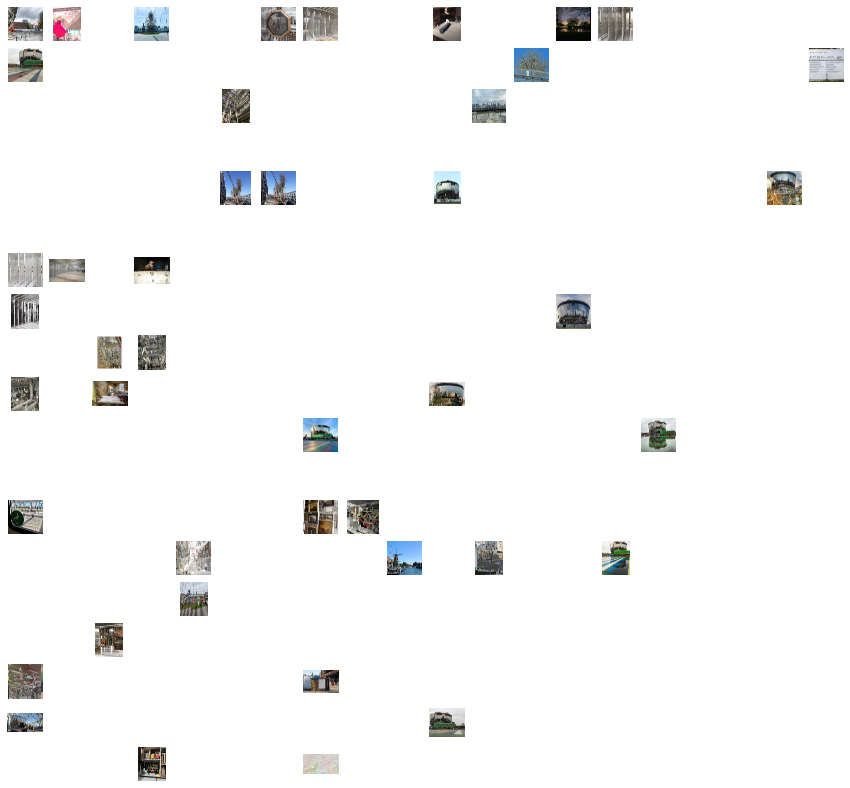

In [9]:
db_all = np.array(get_images_from_imagelist(db_all_file))

macro_cluster_dict = read_json(macro_cluster_file)

pca = PCA(n_components=2)
features_pca_2 = pca.fit_transform(features)

# convert img names to indices to prepare for clustering
macro_cluster_idx_dict = {}
for cluster_name, files in macro_cluster_dict.items():
    macro_cluster_idx_dict[cluster_name] = list(map(image_name_to_index, files))

canvas_size=(20,20)
pad = (0,0) # empty space on the sides
rounds = 10 # n=rounds

xy_taken = []

# collect centroids (represented by index) for each cluster
# structure: [indices_01, indices_02, ..., indices_n_clusters]
centroids_to_plot = []
# structure: [xy_01, xy_02, ...,xy_n_clusters]
xy_to_plot = []
for cluster_name, idxs in macro_cluster_idx_dict.items():
    centroids = get_centroid_idx(idxs, top_n=len(idxs), features=features_pca_2, distance_metric="euclidean")
    centroids_to_plot.append(centroids)
    xy = features_pca_2[centroids]
    xy_to_plot.append(xy)


fig = plt.figure(figsize=(15, 15))
n_rows = canvas_size[0]+pad[0]*2
n_cols = canvas_size[1]+pad[1]*2

for round_ctr in tqdm(range(rounds)):
    # iterature through clusters
    for centroids, xys in zip(centroids_to_plot, xy_to_plot):

        x = xys[:,0]
        y = xys[:,1]
        # normalize to 0-1 and scale to canvas
        x = (x-min(x))/(max(x)-min(x))*canvas_size[0]
        y = (y-min(y))/(max(y)-min(y))*canvas_size[1]
        x = [int(el) for el in x]
        y = [int(el) for el in y]

        # find centroid to plot (lazily iterate through all centroids until we find one with an empty slot)
        for i, idx in enumerate(centroids):
            x_img, y_img = x[i]+pad[0], y[i]+pad[1]
            # plot image on subplot but only if the spot is not taken yet
            if (x_img, y_img) not in xy_taken:
                plot_idx = (((x_img+1) % n_rows)-1)*n_rows + (y_img+1) # xy->field 'number' conversion
                ax = fig.add_subplot(n_rows,n_cols, plot_idx)
                img = plt.imread(db_all_folder + "/" + db_all[idx])
                ax.imshow(img)
                ax.axis('off')
                xy_taken.append((x_img, y_img))
                break

The above clustering visualization on the dummy image dataset is not very interesting so here's how it would look like on the full image dataset:

![](fluff/clustering_vizu.png)

# Do the actors differ in which points of interest they post about? (Image Label Significance Testing)
- only considering post-inauguration images (since before the inauguration not all actors had accces to the Depot)
- 'Misc' category is not considered
- The results may slightly vary from what's shown in the paper because in the original code I took out an outlier user (Marieke van Diemen was posting a large number of staircase pictures so to show that the results are still significant without her she was removed before testing)

image_label  ArtStorage  Misc  Outside  RoofTopTerrace  StairsAtrium
MacroRole                                                           
Private             736  1534     2006             609          2211
Public               12    31       23              21            47 

Chi Square: chi2=14.4, p=0.006106136458866877


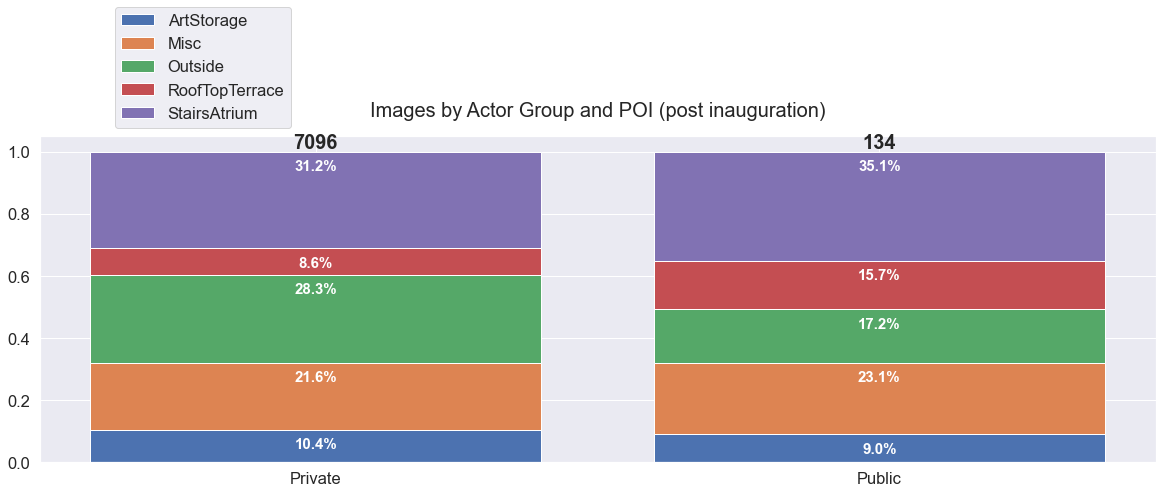

In [10]:
# In the dataframe, each post is one row. But we want each image (multiple per post) to be one row:
rows = []
for idx, row in df["2021-11-06":"2022-01-01"].iterrows():
    for img_label in row["image_label"]:
        rows.append([img_label,row["MacroRole"], "shortcode"])
df_images = pd.DataFrame(rows, columns=["image_label", "MacroRole", "shortcode"])

# Create pivot table
grouping = df_images.groupby(["image_label", "MacroRole"])["shortcode"].count()
# pivot into Microrole(index) x MacroLabel (columns) format
piv = grouping.reset_index().pivot(index="MacroRole", columns="image_label", values="shortcode")
data = piv.fillna(0)
print(data, "\n")

stacked_barchart(data, relative_to_group=True, title='Images by Actor Group and POI (post inauguration)')


print("Chi Square: chi2={:.1f}, p={}".format(*scipy.stats.chi2_contingency(data)[0:2]))